<div class="alert alert-block alert-info">
<center> <h1>  ABCDEats Inc.
</h1> II. CLUSTER ANALYSIS </center> <br>
<center> Customer Segmentation - Part 2 </center> <br>
<center> Data Mining </center> <br>
<center> Hugo Fonseca, </center>
<center> Jéssica Vicente, </center>
<center> Ricardo Pereira </center> <br>
<center>Group 99 </center>

# 1. Libraries and Created Functions

In [419]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import logging
import warnings

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import rankdata
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE


warnings.filterwarnings('ignore')

In [420]:
    # 2.1. FONT 
# from matplotlib.font_manager import fontManager, FontProperties
# path = "/path/to/calibri.ttf"
# fontManager.addfont(path)


    # 2.2. TEMPLATE


def set_matplotlib_style(font_size=8):
        # Replicates the rcParams of seaborn's "whitegrid" 
        plt.style.use("seaborn-v0_8-whitegrid")

        base_style = {
            # Use 10pt font in plots, to match 10pt font in document
            "axes.labelsize": (10 / 8) * font_size,
            "font.size": (10 / 8) * font_size,
            # Make the legend/label fonts a little smaller
            "legend.fontsize": font_size,
            "xtick.labelsize": font_size,
            "ytick.labelsize": font_size,
            # Subplots size/shape
            "figure.subplot.left": 0.098,
            "figure.subplot.right": 0.938,
            "figure.subplot.bottom": 0.12,
            "figure.subplot.top": 0.944,
            "figure.subplot.wspace": 0.071,
                    }
        
        return base_style

plt.rcParams.update(set_matplotlib_style(font_size=8))


In [421]:

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # This function took a lot of time so i wanted to know the progress throughout


def compare_clustering(treatment_data, cluster_range):
    """
    Compare the performance of GMM, hierarchical (Ward), and K-Means for a range of cluster numbers.

    Parameters:
    treatment_data (numpy.ndarray or pandas.DataFrame): Dataset to cluster.
    cluster_range (range): Range of cluster numbers to evaluate (e.g., range(2, 11)).

    Returns:
    dict: Performance metrics for each model and cluster count.
    """
    results = {
        "KMeans": [],
        "GMM": [],
        "Hierarchical": []
    }

    logging.info(f"_______ STARTING A NEW TREATMENT  PROCESSING _______")
    for n_clusters in cluster_range:
        logging.info(f"Evaluating for {n_clusters} clusters...")

        
        logging.info("Running K-Means...")
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        kmeans_labels = kmeans.fit_predict(treatment_data)
        kmeans_silhouette = silhouette_score(treatment_data, kmeans_labels)
        kmeans_ch_score = calinski_harabasz_score(treatment_data, kmeans_labels)
        results["KMeans"].append({
            "n_clusters": n_clusters,
            "silhouette": kmeans_silhouette,
            "calinski_harabasz": kmeans_ch_score
        })
        logging.info(f"K-Means completed for {n_clusters} clusters.")

        
        logging.info("Running Gaussian Mixture Model...")
        gmm = GaussianMixture(n_components=n_clusters, covariance_type='spherical', random_state=42)
        gmm_labels = gmm.fit_predict(treatment_data)
        gmm_silhouette = silhouette_score(treatment_data, gmm_labels)
        gmm_ch_score = calinski_harabasz_score(treatment_data, gmm_labels)
        results["GMM"].append({
            "n_clusters": n_clusters,
            "silhouette": gmm_silhouette,
            "calinski_harabasz": gmm_ch_score
        })
        logging.info(f"Gaussian Mixture Model completed for {n_clusters} clusters.")

        
        logging.info("Running Hierarchical Clustering...")
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        hierarchical_labels = hierarchical.fit_predict(treatment_data)
        hierarchical_silhouette = silhouette_score(treatment_data, hierarchical_labels)
        hierarchical_ch_score = calinski_harabasz_score(treatment_data, hierarchical_labels)
        results["Hierarchical"].append({
            "n_clusters": n_clusters,
            "silhouette": hierarchical_silhouette,
            "calinski_harabasz": hierarchical_ch_score
        })
        logging.info(f"Hierarchical Clustering completed for {n_clusters} clusters.")

    logging.info("Clustering evaluation completed.")
    
    
    kmeans_silhouette = pd.Series([results["KMeans"][i]['silhouette'] for i in range(len(cluster_range))])
    kmeans_calinski_harabasz = pd.Series([results["KMeans"][i]['calinski_harabasz'] for i in range(len(cluster_range))])

    gmm_silhouette = pd.Series([results["GMM"][i]['silhouette'] for i in range(len(cluster_range))])
    gmm_calinski_harabasz = pd.Series([results["GMM"][i]['calinski_harabasz'] for i in range(len(cluster_range))])


    hier_silhouette = pd.Series([results["Hierarchical"][i]['silhouette'] for i in range(len(cluster_range))])
    hier_calinski_harabasz = pd.Series([results["Hierarchical"][i]['calinski_harabasz'] for i in range(len(cluster_range))])



    silhouettes_dict = {
        "KMeans": kmeans_silhouette,
        "GMM": gmm_silhouette,
        "Hierarchical": hier_silhouette
        }

    calinski_h_dict = {
        "KMeans": kmeans_calinski_harabasz,
        "GMM": gmm_calinski_harabasz,
        "Hierarchical": hier_calinski_harabasz
        }



    return pd.DataFrame(silhouettes_dict).set_index(pd.Series(cluster_range)), pd.DataFrame(calinski_h_dict).set_index(pd.Series(cluster_range))

In [422]:



def plot_side_by_side(df1, df2, ax1, ax2):
    """
    Plots two DataFrames side by side using line plots on the provided axes.
    Also plots the average for each x-value (number of clusters) across columns on the corresponding axes.

    Parameters:
    df1, df2: DataFrames to be plotted.
    ax1, ax2: Axes on which to plot the data.
    """
    
    markers = ['+', 'x', '^']
    colors = sns.color_palette('pastel6', n_colors=max(len(df1.columns), len(df2.columns)))

    
    for idx, column in enumerate(df1.columns):
        df1[column].plot(ax=ax1, color=colors[idx], marker=(markers[idx] if markers else None), label=column, markersize=4, linewidth=1)
    ax1.set_xlabel('Number of Clusters', fontsize=7)
    ax1.set_ylabel('Silhouette', fontsize=7)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    
    df1_avg = df1.mean(axis=1)
    ax1.plot(df1.index, df1_avg, color='black', linestyle='--', label='Average', linewidth=0.8)
    
    ax1.legend()

    
    for idx, column in enumerate(df2.columns):
        df2[column].plot(ax=ax2, color=colors[idx], marker=(markers[idx] if markers else None), label=column, markersize=4, linewidth=1)
    ax2.set_xlabel('Number of Clusters', fontsize=7)
    ax2.set_ylabel('Calinski-Harabasz', fontsize=7)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    
    df2_avg = df2.mean(axis=1)
    ax2.plot(df2.index, df2_avg, color='black', linestyle='--', label='Average', linewidth=0.8)
    
    ax2.legend()


In [423]:

def plot_cluster_validation(dataframe, cluster_col='cluster_group', n_components=2, random_state=42, alpha=0.4, s=2):
    """
    Plots 2D PCA and UMAP visualizations side by side for clustering validation.

    Parameters:
        dataframe (pd.DataFrame): The input clustered DataFrame.
        cluster_col (str): The column name with cluster labels.
        n_components (int): Number of components for PCA and UMAP (default is 2).
        random_state (int): Random state for reproducibility (default is 42).
    """
    from sklearn.decomposition import PCA
    from umap import UMAP
    
    features = dataframe.drop(columns=[cluster_col])
    cluster_labels = dataframe[cluster_col]
    
    
    pca = PCA(n_components=n_components, random_state=random_state)
    pca_result = pca.fit_transform(features)
    
    
    umap_reducer = UMAP(n_components=n_components, random_state=random_state)
    umap_result = umap_reducer.fit_transform(features)
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    
    scatter_pca = axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='tab10', alpha=alpha, s=s)
    axes[0].set_title('PCA Clustering Validation')
    axes[0].set_xlabel('PCA Component 1')
    axes[0].set_ylabel('PCA Component 2')
    legend1 = axes[0].legend(*scatter_pca.legend_elements(), title="Clusters")
    axes[0].add_artist(legend1)
    
    
    scatter_umap = axes[1].scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels, cmap='tab10', alpha=alpha, s=s)
    axes[1].set_title('UMAP Clustering Validation')
    axes[1].set_xlabel('UMAP Component 1')
    axes[1].set_ylabel('UMAP Component 2')
    legend2 = axes[1].legend(*scatter_umap.legend_elements(), title="Clusters")
    axes[1].add_artist(legend2)
    
    
    plt.tight_layout()
    plt.show()


# 2. Imported data

In [424]:
with open('pre_processed_dataframe.csv', 'r') as file:
    preprocessed_df = pd.read_csv(file)

with open('diverse_customers.csv', 'r') as file:
    diverse_customers = pd.read_csv(file)
    
with open('feats_lists.json', 'r') as file:
    feats_lists = dict(json.load(file))
    
with open('outlier_columns.json', 'r') as file:
    outlier_columns = dict(json.load(file))

In [425]:
cuisines = feats_lists['cuisines']

del feats_lists['cuisines']

cuisines

{'treatment_1': ['CUI_Asian_treatment_1',
  'CUI_American_treatment_1',
  'CUI_OTHER_treatment_1']}

# 3. TREATMENTS, ALGORITHMS AND N CLUSTER CHOICES;

In [ ]:
rfm_treatment_1_silhouette, rfm_treatment_1_calinski  = compare_clustering(preprocessed_df.loc[ preprocessed_df[outlier_columns['rfm']['treatment_1']] != -1 , feats_lists['rfm']['treatment_1']], range(2, 7))
rfm_treatment_2_silhouette, rfm_treatment_2_calinski = compare_clustering(preprocessed_df.loc[ preprocessed_df[outlier_columns['rfm']['treatment_2']] != -1 , feats_lists['rfm']['treatment_2']], range(2, 7))
rfm_treatment_3_silhouette, rfm_treatment_3_calinski = compare_clustering(preprocessed_df.loc[ preprocessed_df[outlier_columns['rfm']['treatment_3']] != -1 , feats_lists['rfm']['treatment_3']], range(2, 7))

In [ ]:
time_treatment_1_silhouette, time_treatment_1_calinski = compare_clustering(preprocessed_df.loc[ preprocessed_df[outlier_columns['time']['treatment_1']] != -1 , feats_lists['time']['treatment_1']], range(2, 7))
time_treatment_2_silhouette, time_treatment_2_calinski = compare_clustering(preprocessed_df.loc[ preprocessed_df[outlier_columns['time']['treatment_2']] != -1 , feats_lists['time']['treatment_2']], range(2, 7))
time_treatment_3_silhouette, time_treatment_3_calinski = compare_clustering(preprocessed_df.loc[ preprocessed_df[outlier_columns['time']['treatment_3']] != -1 , feats_lists['time']['treatment_3']], range(2, 7))

In [ ]:
diverse_customers_silhouette, diverse_customers_calinski = compare_clustering(diverse_customers.loc[ diverse_customers[outlier_columns['cuisines']['treatment_1']] != -1, cuisines['treatment_1'] ], range(2, 7))

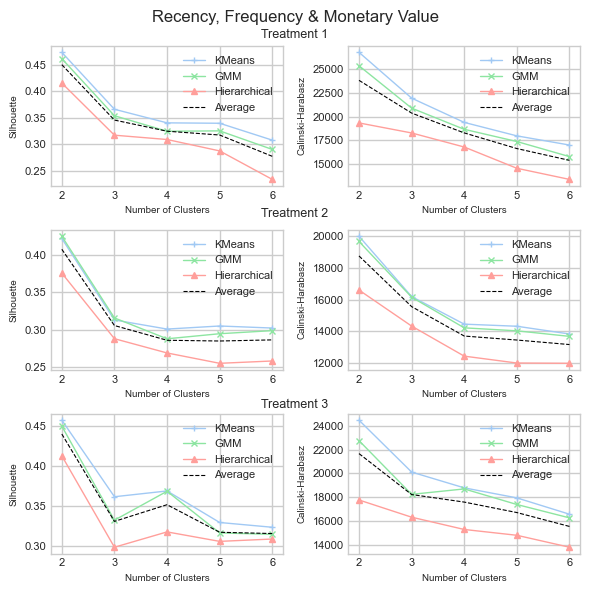

In [429]:
fig, axes = plt.subplots(3, 2, figsize=(6, 6))


plot_side_by_side(rfm_treatment_1_silhouette, rfm_treatment_1_calinski, 
                  ax1=axes[0, 0], ax2=axes[0, 1])


plot_side_by_side(rfm_treatment_2_silhouette, rfm_treatment_2_calinski, 
                  ax1=axes[1, 0], ax2=axes[1, 1])


plot_side_by_side(rfm_treatment_3_silhouette, rfm_treatment_3_calinski, 
                  ax1=axes[2, 0], ax2=axes[2, 1])





fig.text(0.5, 0.938, 'Treatment 1', fontsize=9, ha='center', va='center')
fig.text(0.5, 0.64, 'Treatment 2', fontsize=9, ha='center', va='center')
fig.text(0.5, 0.321, 'Treatment 3', fontsize=9, ha='center', va='center')

plt.suptitle('Recency, Frequency & Monetary Value')
plt.tight_layout()
plt.subplots_adjust(top=0.92)


plt.show()


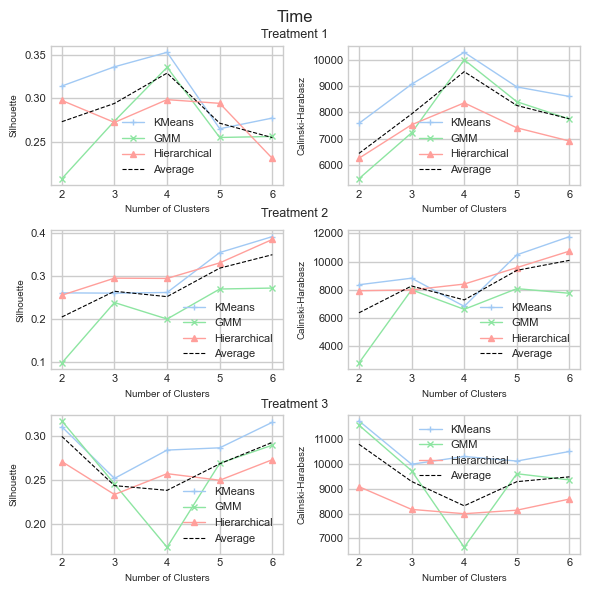

In [430]:
fig, axes = plt.subplots(3, 2, figsize=(6, 6))


plot_side_by_side(time_treatment_1_silhouette, time_treatment_1_calinski, 
                  ax1=axes[0, 0], ax2=axes[0, 1])


plot_side_by_side(time_treatment_2_silhouette, time_treatment_2_calinski, 
                  ax1=axes[1, 0], ax2=axes[1, 1])


plot_side_by_side(time_treatment_3_silhouette, time_treatment_3_calinski, 
                  ax1=axes[2, 0], ax2=axes[2, 1])





fig.text(0.5, 0.938, 'Treatment 1', fontsize=9, ha='center', va='center')
fig.text(0.5, 0.64, 'Treatment 2', fontsize=9, ha='center', va='center')
fig.text(0.5, 0.321, 'Treatment 3', fontsize=9, ha='center', va='center')

plt.suptitle('Time')
plt.tight_layout()
plt.subplots_adjust(top=0.92)


plt.show()


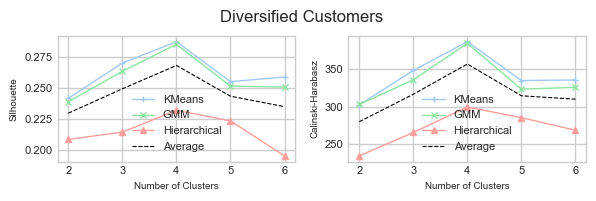

In [431]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2))  # Two axes side by side

plot_side_by_side(diverse_customers_silhouette, diverse_customers_calinski,
                  ax1=axes[0], ax2=axes[1])

plt.suptitle('Diversified Customers')
plt.tight_layout()
plt.subplots_adjust(top=0.85)


plt.show()

# 4. FINAL CLUSTERING

In [482]:
rfm_fit_data = preprocessed_df.loc[ preprocessed_df[outlier_columns['rfm']['treatment_1']] != -1 , feats_lists['rfm']['treatment_1']]
time_fit_data = preprocessed_df.loc[ preprocessed_df[outlier_columns['time']['treatment_1']] != -1 , feats_lists['time']['treatment_1']]
diverse_customers_fit_data = diverse_customers.loc[ diverse_customers[outlier_columns['cuisines']['treatment_1']] != -1, cuisines['treatment_1'] ]

In [483]:
rfm_cluster_model = KMeans(n_clusters=2, init='k-means++', random_state=42).fit(rfm_fit_data)
time_cluster_model = GaussianMixture(n_components=4, random_state=42).fit(time_fit_data)
diverse_customers_cluster_model = KMeans(n_clusters=4, init='k-means++', random_state=42).fit(diverse_customers_fit_data)

In [484]:
rfm_cluster_results = preprocessed_df[feats_lists['rfm']['treatment_1']]
rfm_cluster_results['cluster_group'] = rfm_cluster_model.predict(preprocessed_df[feats_lists['rfm']['treatment_1']])

time_cluster_results = preprocessed_df[feats_lists['time']['treatment_1']]
time_cluster_results['cluster_group'] = time_cluster_model.predict(preprocessed_df[feats_lists['time']['treatment_1']])

diverse_customers_cluster_results = diverse_customers_fit_data
diverse_customers_cluster_results['cluster_group'] = diverse_customers_cluster_model.predict(diverse_customers_fit_data)

# 6. Cluster exploration

In [485]:
plot_cluster_validation(rfm_cluster_results, cluster_col='cluster_group', n_components=2, random_state=42)

In [486]:
plot_cluster_validation(time_cluster_results, cluster_col='cluster_group', n_components=2, random_state=2825043)

In [487]:
plot_cluster_validation(diverse_customers_cluster_results, cluster_col='cluster_group', n_components=2, random_state=42, s=8, alpha=0.8)

In [488]:
rfm_centroids = pd.DataFrame(data=rfm_cluster_model.cluster_centers_, columns=[i.replace("_treatment_1", '') for i in rfm_cluster_model.feature_names_in_])
time_centroids = pd.DataFrame(data=time_cluster_model.means_, columns=[i.replace("_treatment_1", '') for i in time_cluster_model.feature_names_in_])
diverse_customers_centroids = pd.DataFrame(data=diverse_customers_cluster_model.cluster_centers_, columns=[i.replace("_treatment_1", '') for i in diverse_customers_cluster_model.feature_names_in_])

In [489]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels)
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.tight_layout()
    plt.show()


2025-01-06 07:32:13,837 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-01-06 07:32:13,846 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


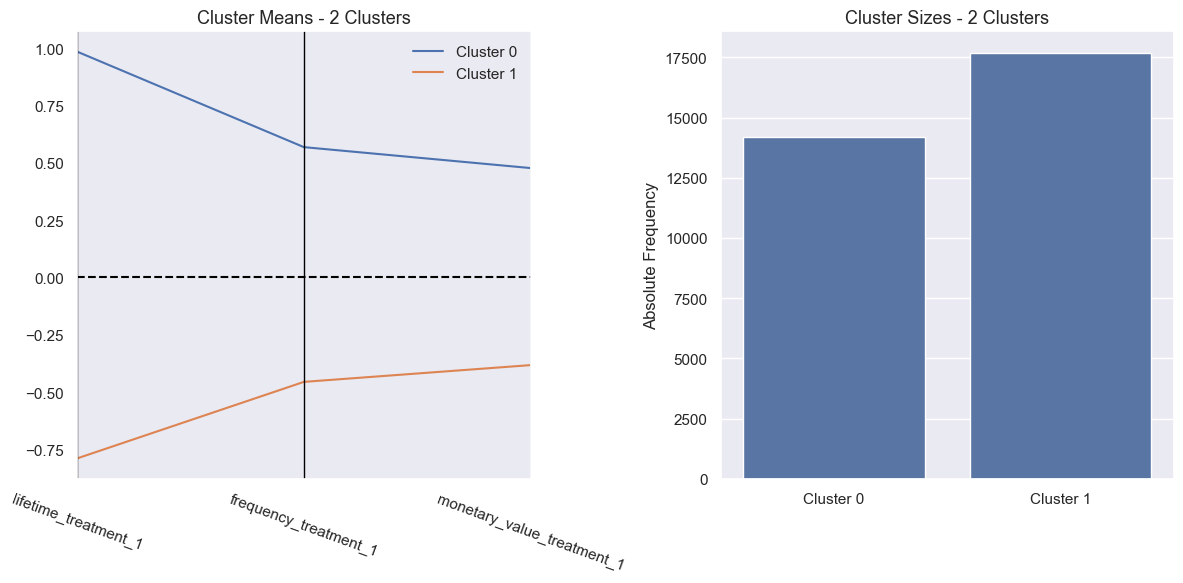

2025-01-06 07:32:14,336 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-06 07:32:14,343 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


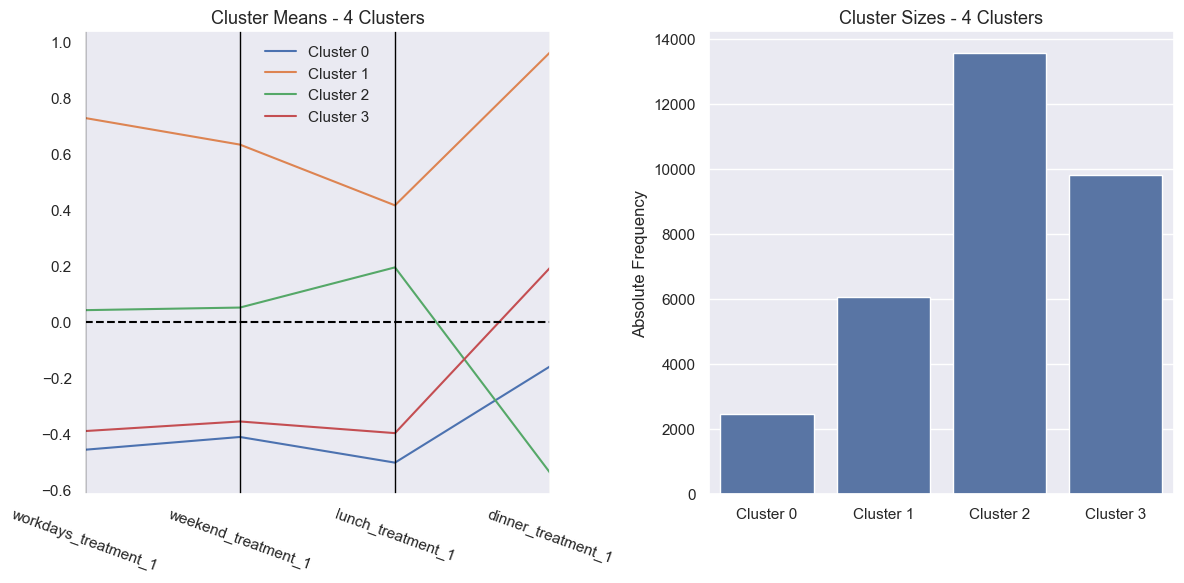

2025-01-06 07:32:15,037 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-06 07:32:15,051 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


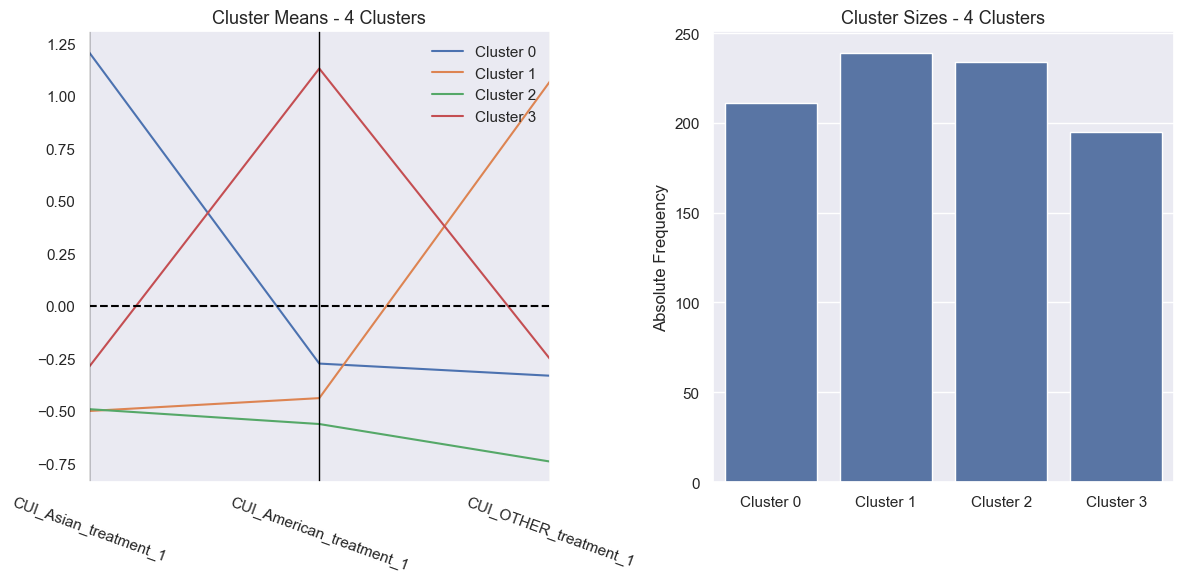

In [490]:
cluster_profiles(df=rfm_cluster_results, label_columns=['cluster_group'], figsize=(12, 6), compar_titles=None)
cluster_profiles(df=time_cluster_results, label_columns=['cluster_group'], figsize=(12, 6), compar_titles=None)
cluster_profiles(df=diverse_customers_cluster_results, label_columns=['cluster_group'], figsize=(12, 6), compar_titles=None)


In [491]:
rfm_cluster_results['cluster_group_pretty_labels'] = rfm_cluster_results['cluster_group'].map({1:'Low Value Customers', 0:'High Value Customers'})
time_cluster_results['cluster_group_pretty_labels'] = time_cluster_results['cluster_group'].map({0:'Casual Diner', 2: 'Lunch-Regulars', 3: 'Casual Diner', 1: 'Out-Eaters'})
diverse_customers_cluster_results['cluster_group_pretty_labels'] = diverse_customers_cluster_results['cluster_group'].map({0:'Asian Market', 1:'Jack-Of-All-Trades', 2:'American Market', 3:'Others'})

In [492]:
interaction_df = pd.Series(rfm_cluster_results['cluster_group_pretty_labels'] + ' // ' + time_cluster_results['cluster_group_pretty_labels'])

out_eaters_high_value = preprocessed_df.loc[ interaction_df == 'High Value Customers // Out-Eaters']
lunch_regulars_high_value = preprocessed_df.loc[ interaction_df == 'High Value Customers // Lunch-Regulars']
casual_diner_high_value = preprocessed_df.loc[ interaction_df == 'High Value Customers // Casual Diner']

customer_region
A    0.700000
B    0.113814
C    0.098557
-    0.028866
F    0.028454
D    0.014639
E    0.008866
G    0.006392
H    0.000412
Name: proportion, dtype: float64


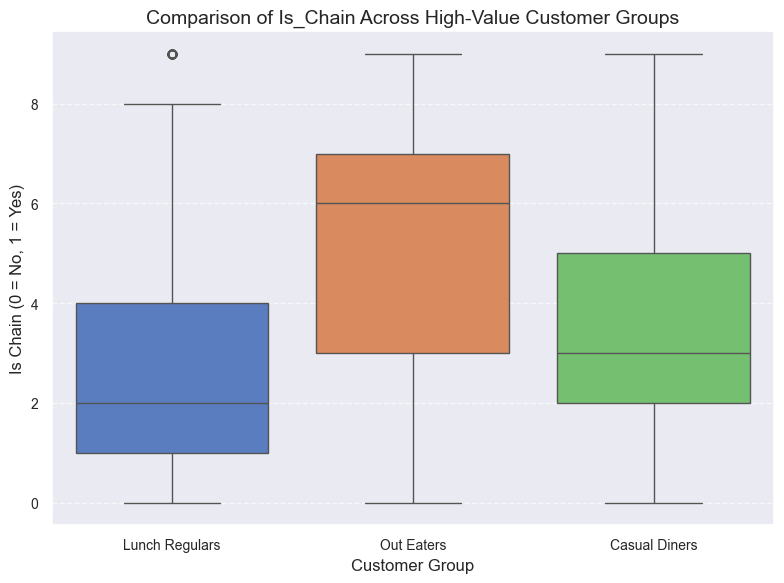

In [493]:
print(lunch_regulars_high_value['customer_region'].value_counts(normalize=True))


data = pd.concat([
    lunch_regulars_high_value.assign(group='Lunch Regulars'),
    out_eaters_high_value.assign(group='Out Eaters'),
    casual_diner_high_value.assign(group='Casual Diners')
])


plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='group', y='is_chain', palette='muted')


plt.title('Comparison of Is_Chain Across High-Value Customer Groups', fontsize=14)
plt.xlabel('Customer Group', fontsize=12)
plt.ylabel('Is Chain (0 = No, 1 = Yes)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

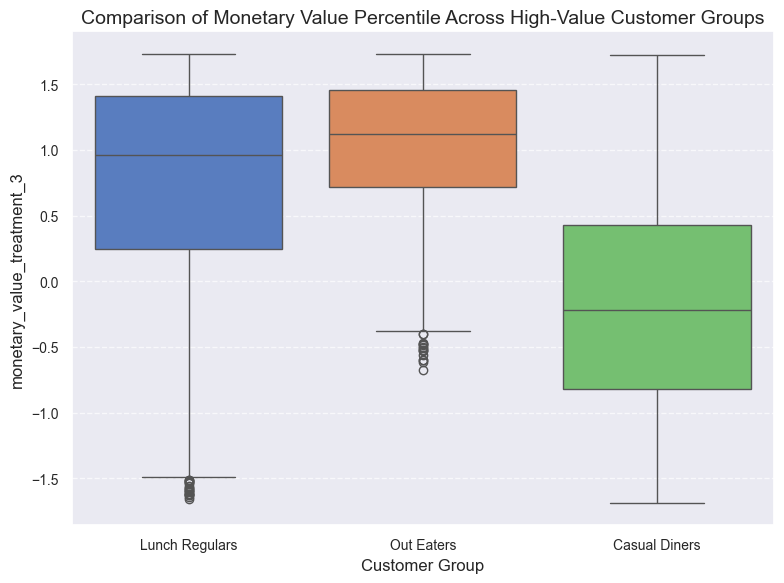

In [494]:

plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='group', y='monetary_value_treatment_3', palette='muted')


plt.title('Comparison of Monetary Value Percentile Across High-Value Customer Groups', fontsize=14)
plt.xlabel('Customer Group', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

In [495]:
out_eaters_high_value[cuisines['treatment_1']]

,CUI_Asian_treatment_1,CUI_American_treatment_1,CUI_OTHER_treatment_1
100,0.000000,0.000000,0.000000
104,0.000000,0.000000,0.470443
135,1.907339,0.000000,0.000000
163,0.000000,0.000000,0.000000
190,0.000000,0.000000,0.000000
...,...,...,...
26817,6.478155,0.000000,0.000000
27011,5.541713,0.000000,0.000000
27162,14.000000,0.000000,0.000000
27808,11.826646,0.534711,5.320746


In [505]:
print(pd.Series(diverse_customers_cluster_model.predict(out_eaters_high_value[cuisines['treatment_1']])).map({0:'Asian Market', 1:'Jack-Of-All-Trades', 2:'American Market', 3:'Others'}).value_counts(normalize=True))

print()
print(pd.Series(diverse_customers_cluster_model.predict(lunch_regulars_high_value[cuisines['treatment_1']])).map({0:'Asian Market', 1:'Jack-Of-All-Trades', 2:'American Market', 3:'Others'}).value_counts(normalize=True))
print()

print(pd.Series(diverse_customers_cluster_model.predict(casual_diner_high_value[cuisines['treatment_1']])).map({0:'Asian Market', 1:'Jack-Of-All-Trades', 2:'American Market', 3:'Others'}).value_counts(normalize=True))

Others                0.312512
Asian Market          0.293087
Jack-Of-All-Trades    0.279375
American Market       0.115026
Name: proportion, dtype: float64

Asian Market          0.581856
Others                0.206186
American Market       0.146186
Jack-Of-All-Trades    0.065773
Name: proportion, dtype: float64

Others                0.286170
American Market       0.268024
Jack-Of-All-Trades    0.258460
Asian Market          0.187347
Name: proportion, dtype: float64


In [462]:
print(out_eaters_high_value['customer_region'].value_counts(normalize=True))


customer_region
B    0.468215
C    0.320708
A    0.104301
D    0.055767
E    0.028930
G    0.014275
-    0.005329
F    0.002094
H    0.000381
Name: proportion, dtype: float64


In [447]:
print(casual_diner_high_value['customer_region'].value_counts(normalize=True))

customer_region
A    0.509610
B    0.192192
C    0.176577
F    0.031331
D    0.029730
E    0.026527
-    0.024224
G    0.008909
H    0.000901
Name: proportion, dtype: float64
